### In this notebook I use some natural language processing (NLP) method with scikit learn, to spot potential multihosts in Bologna Airbnb host community. 
### I'm going to do that exploiting textual descriptions of the announces ("description", "space" and "summary" columns above all) into an Inside Airbnb dataset (http://insideairbnb.com/get-the-data.html by Murray Cox). The reason is that a lot of announces seem to have very similar description although they belong to different hosts. That means that apparently there's a copy-paste abuse among hosts that MAYBE belong to the same home structure. Why one should ever do that? Why a big Airbnb commercial player is pushed to create different "host" entities to handle his property? Look at that:

In [1]:
import pandas as pd

# I've picked up the latest dataset - the zipped listing, since it is richer in textual info:
listings = pd.read_csv("listings_detailed/2_2020.csv")

set(listings[listings['calculated_host_listings_count'] > 10]\
    .sort_values('calculated_host_listings_count', ascending=False).host_name)

{'28',
 'Agostino',
 'Alessandro',
 'Andrea',
 'Arianna',
 'Bnbbologna',
 'Canguro Properties',
 'Flat In Italy',
 'Franco',
 'GetTheKey',
 'Halldis Apartments & Villas',
 'Luca',
 'Marco',
 'Michela Borghetto',
 'Rambaldo',
 'Realkasa',
 'Silvia',
 'Stefano',
 'The Place',
 'Vito',
 'Welcome To Bologna & Ferrara!'}

### This is the list of players with more than 10 announces on the platform. As you can see, around the 50% of them has a definitely "human" and "italian" name, in spite of their commercial vocation. Agostino, Franco, Silvia... They inspire confidence, intimacy, autenticity. Isn't strange? Would you let your uncle Mario represent your italian guesthouse in full? Apparently, you should! Multihosts and commercial partners are a problem for Airbnb storytelling because they're faceless, and they're not consistent with the idea of a resident host, keen to show and explain his/her exotic city to guests. That's perhaps why the host identity tends to be humanized and parcellized on the platform.

### Now, let's have a look into this dataset:

In [ ]:
listings.head(5)

### As we said above, we would like to compare textual features of every single announce with each other. Let's pick up a column and a threshold. 

In [ ]:
# I set the COLUMN I want to use for similarity
# and the SIMILARITY THRESHOLD under which 2 announces are not considered similar
# (caution: column naming is sometimes inconsistent across dataframes)

text = "description"
similarity_ts = 0.65

In [ ]:
# I take only announces of entire houses or apartments. I exclude ones with empty value.

summaries = [ (summary,listings['id'][ix])
             for ix, summary in enumerate(list(listings[text])) 
             if str(summary) != 'nan' 
             and listings['room_type'][ix] == 'Entire home/apt']

corpus = [i[0] for i in summaries]
id_name = [i[1] for i in summaries]

### Here we are. With scikit learn tfidf we vectorize each text, while with the linear kernel we measures the similarity. So, from a matrix we can retrieve a list of couples, paired by similarity.
This code cell can be quite slow. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = linear_kernel(tfidf)
dataset = pd.DataFrame({c:similarity_matrix[:, ix] for ix,c in enumerate(id_name)}, index=id_name)

s = [(ix,val) for ix,val in dataset.stack().sort_values(ascending=False).iteritems() 
     if ix[0] != ix[1] and val > similarity_ts]

In [ ]:
check = []
tuples = []
for i in s:
    if set(i[0]) not in check:
        tuples.append(i)
        check.append(set(i[0]))        

### Let's unstack our results!

In [ ]:
stack = []

def get_host(ix): 
    return byId('host_id', ix)

def byId(what, i):
    return listings.loc[listings['id'] == i, what].iloc[0]

hosts = []
for ids,sim in s:
    host_0 = get_host(ids[0])
    host_1 = get_host(ids[1])
    hosts.append(host_1)
    hosts.append(host_0)
    stack.append(( (host_0, ids[0]), (host_1, ids[1]) , sim ))
    
stack = [i for i in stack if i[0][0] != i[1][0]]

In [ ]:
relevant_columns = ['host_id', 'host_name','id', 'name','space', 'description', 'summary']

similar_announces = []
for i in stack:
    
    similar_announces.append(listings.loc[listings['id'] == i[0][1]])
    similar_announces.append(listings.loc[listings['id'] == i[1][1]])

In [ ]:
similar_announces = pd.concat(similar_announces)[relevant_columns].drop_duplicates()
similar_announces.head(100)


In [ ]:
# if you want a .csv output:

similar_announces.to_csv("other_data/similar_announce_%s.xlsx" % text)

### We can observe several phenomena at a quick glance. It turns out that often the same host has more than one id. It can happen also that a single announce appears on the platform multiple times, with different hosts, but it's rarer. Generally, there's a number of totally different hosts having different announces but identical descriptions.

### This is a qualitative approach. We can't make any quantitative statement, nor state that a host is unequivocally part of a bigger group of hosts. But still, I think it's a useful method for describing our datasets.

In [2]:
d = {}
for i in set(listings.host_id[:100]):
    d[i] = list(listings[listings.host_id == i].id)

In [25]:
import networkx as nx

g = nx.Graph()

for k,v in d.items():
    
    g.add_nodes_from([(k,{'color':'green'})])
    
    listings = [(i,{'color':'orange'}) for i in v] 
    arrows = [(k,i) for i in v]
    
    g.add_nodes_from(listings)
    g.add_edges_from(arrows)

In [21]:
g.nodes[2212785]

{'color': 'orange'}

In [26]:
color_map = []
for node in g.nodes:
    try:
        color_map.append(g.nodes[node]['color'])
    except KeyError:
        color_map.append("blue")

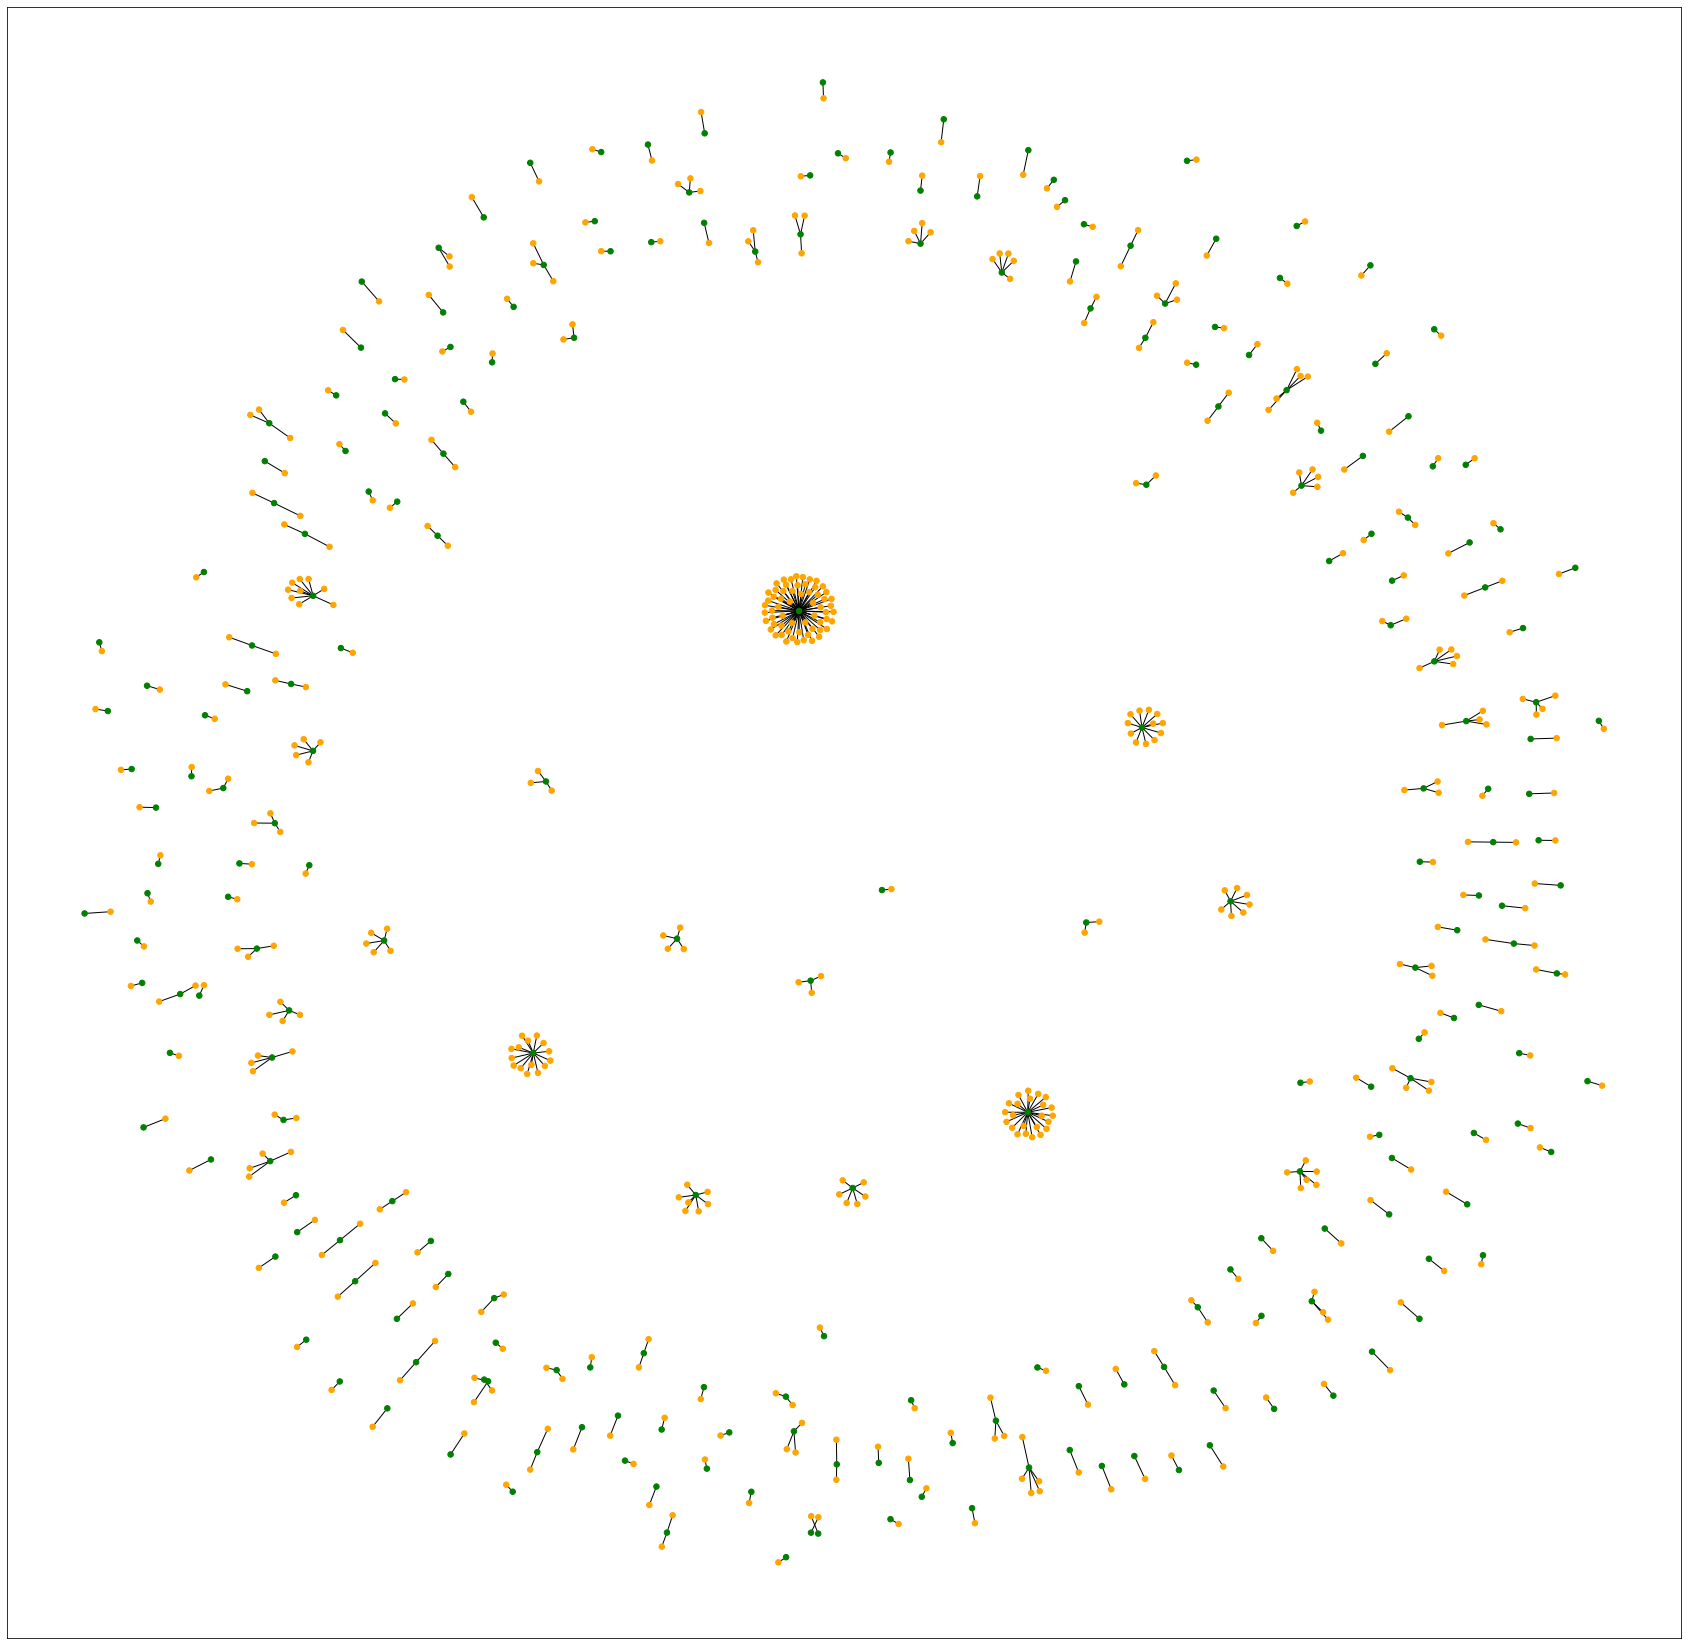

In [27]:
import matplotlib.pyplot as plt
#import PyQt5
#%matplotlib qt

fig, ax = plt.subplots(figsize=(30,30))
nx.draw_networkx(g, with_labels=False, node_size=30, node_color=color_map)